# Supervised learning: predicting an output variable from high-dimensional observations
Supervised learning consists in learning the link between two datasets: the observed data `X` and an external variable `y` that we are trying to predict, usually called “target” or “labels”. Most often, `y` is a 1D array of length `n_samples`.

All supervised estimators in scikit-learn implement a `fit(X, y)` method to fit the model and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.
If the goal is to predict a distict target variable it's classification. If the target varible is continuous the problem is a regression task.

## Nearest neighbor and the curse of dimensionality
##### Classifying irises:
The iris dataset is a classification task consisting in identifying 3 different types of irises (Setosa, Versicolour, and Virginica) from their petal and sepal length and width:

In [1]:
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target
np.unique(iris_y)

array([0, 1, 2])

### K-Nearest neighbors classifier
##### Training set and testing set
Given a new observation `X_test`, find in the training set the observation with the closest feature vector.
While experimenting with any learning algorithm, it is important not to test the prediction of an estimator on the data used to fit the estimator as this would not be evaluating the performance of the estimator on new data. This is why datasets are often split into *train* and *test* data.

In [2]:
np.random.seed(0)
indices = np.random.permutation(len(iris_X))
iris_X_train = iris_X[indices[:-10]]
iris_y_train = iris_y[indices[:-10]]
iris_X_test = iris_X[indices[-10:]]
iris_y_test = iris_y[indices[-10:]]

In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
knn = KNeighborsClassifier()
knn.fit(iris_X_train, iris_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [5]:
knn.predict(iris_X_test)

array([1, 2, 1, 0, 0, 0, 2, 1, 2, 0])

In [6]:
iris_y_test

array([1, 1, 1, 0, 0, 0, 2, 1, 2, 0])

### The curse of dimensionality
As the number of dimensions/features grow the amount of data needed to generalize accuracy grows exponentially.

## Linear model: from regression to sparsity
##### Diabetes dataset

The diabetes dataset consists of 10 physiological variables measure on 442 patients, and an indication of disease progression after one year:

In [7]:
diabetes = datasets.load_diabetes()
diabetes_X_train = diabetes.data[:-20]
diabetes_X_test  = diabetes.data[-20:]
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test  = diabetes.target[-20:]

### Linear regression

*LinearRegression*, fits a linear model to the data set by adjusting a set of parameters in order to make the sum of the squared residuals of the model as small as possible.

In [8]:
from sklearn import linear_model

In [9]:
regr = linear_model.LinearRegression()
regr.fit(diabetes_X_train, diabetes_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
print(regr.coef_)

[ 3.03499549e-01 -2.37639315e+02  5.10530605e+02  3.27736980e+02
 -8.14131709e+02  4.92814588e+02  1.02848452e+02  1.84606489e+02
  7.43519617e+02  7.60951722e+01]


In [11]:
# The mean square error
np.mean((regr.predict(diabetes_X_test) - diabetes_y_test)**2)

2004.5676026898211

In [12]:
# Explained variance score: 1 is perfect prediction
# and 0 means that there is no linear relationship
# between X and y.
regr.score(diabetes_X_test, diabetes_y_test)

0.5850753022690574

### Shrinkage
If there are few data points per dimension, noise in the observations induces high variance:

In [18]:
X = np.c_[ .5, 1].T
y = [.5, 1]
test = np.c_[ 0, 2].T

In [19]:
regr = linear_model.LinearRegression()

In [22]:
import matplotlib.pyplot as plt 

In [25]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [26]:
np.random.seed(0)

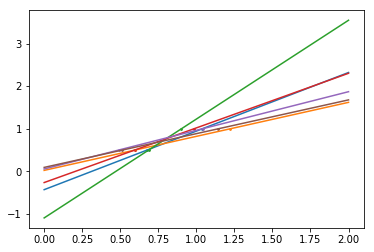

In [27]:
for _ in range(6): 
    this_X = .1 * np.random.normal(size=(2, 1)) + X
    regr.fit(this_X, y)
    plt.plot(test, regr.predict(test)) 
    plt.scatter(this_X, y, s=3)  

A solution in high-dimensional statistical learning is to shrink the regression coefficients to zero: any two randomly chosen set of observations are likely to be uncorrelated. This is called `Ridge` regression:

In [28]:
regr = linear_model.Ridge(alpha=.1)

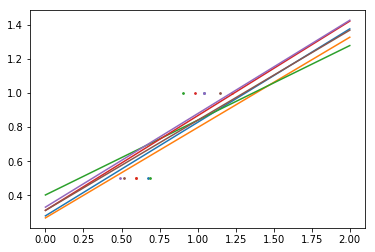

In [29]:
plt.figure() 
np.random.seed(0)
for _ in range(6): 
    this_X = .1 * np.random.normal(size=(2, 1)) + X
    regr.fit(this_X, y)
    plt.plot(test, regr.predict(test)) 
    plt.scatter(this_X, y, s=3) 

This is an example of *bias/variance tradeoff*: the larger the ridge alpha parameter, the higher the bias and the lower the variance.

We can choose `alpha` to minimize left out error, this time using the diabetes dataset rather than our synthetic data:

In [30]:
>>> alphas = np.logspace(-4, -1, 6)
>>> print([regr.set_params(alpha=alpha)
...            .fit(diabetes_X_train, diabetes_y_train)
...            .score(diabetes_X_test, diabetes_y_test)
...        for alpha in alphas])

[0.585111068388353, 0.5852073015444677, 0.5854677540698492, 0.5855512036503915, 0.5830717085554162, 0.5705899943728011]


To improve the conditioning of the problem (i.e. mitigating the The curse of dimensionality), it would be interesting to select only the informative features and set non-informative ones, like feature 2 to 0. Ridge regression will decrease their contribution, but not set them to zero. Another penalization approach, called Lasso (least absolute shrinkage and selection operator), can set some coefficients to zero. Such methods are called sparse method and sparsity can be seen as an application of Occam’s razor: prefer simpler models.

In [31]:
regr = linear_model.Lasso()
scores = [regr.set_params(alpha=alpha)
              .fit(diabetes_X_train, diabetes_y_train)
              .score(diabetes_X_test, diabetes_y_test)
          for alpha in alphas]
best_alpha = alphas[scores.index(max(scores))]
regr.alpha = best_alpha
regr.fit(diabetes_X_train, diabetes_y_train)

Lasso(alpha=0.025118864315095794, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
print(regr.coef_)

[   0.         -212.43764548  517.19478111  313.77959962 -160.8303982
   -0.         -187.19554705   69.38229038  508.66011217   71.84239008]


### Classification
For classification, as in the labeling iris task, linear regression is not the right approach as it will give too much weight to data far from the decision frontier. A linear approach is to fit a sigmoid function or logistic function

In [34]:
log = linear_model.LogisticRegression(solver='lbfgs', C=1e5,
                                      multi_class='multinomial')
log.fit(iris_X_train, iris_y_train) 

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)



Shrinkage and sparsity with logistic regression

The C parameter controls the amount of regularization in the LogisticRegression object: a large value for C results in less regularization. penalty="l2" gives Shrinkage (i.e. non-sparse coefficients), while penalty="l1" gives Sparsity.

#### Exercise

Try classifying the digits dataset with nearest neighbors and a linear model. Leave out the last 10% and test prediction performance on these observations.


In [35]:
from sklearn import datasets, neighbors, linear_model

digits = datasets.load_digits()
X_digits = digits.data / digits.data.max()
y_digits = digits.target

In [36]:
n_samples = len(X_digits)

X_train = X_digits[:int(.9 * n_samples)]
y_train = y_digits[:int(.9 * n_samples)]
X_test = X_digits[int(.9 * n_samples):]
y_test = y_digits[int(.9 * n_samples):]

In [37]:

knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000,
                                           multi_class='multinomial')

print('KNN score: %f' % knn.fit(X_train, y_train).score(X_test, y_test))
print('LogisticRegression score: %f'
      % logistic.fit(X_train, y_train).score(X_test, y_test))

KNN score: 0.961111
LogisticRegression score: 0.933333


### Support vector machines (SVMs)

#### Linear SVMs



Support Vector Machines  belong to the discriminant model family: they try to find a combination of samples to build a plane maximizing the margin between the two classes. Regularization is set by the `C` parameter: a small value for `C` means the margin is calculated using many or all of the observations around the separating line (more regularization); a large value for `C` means the margin is calculated on observations close to the separating line (less regularization).

SVMs can be used in regression –`SVR` (Support Vector Regression)–, or in classification –`SVC` (Support Vector Classification).

In [39]:
from sklearn import svm
svc = svm.SVC(kernel='linear')
svc.fit(iris_X_train, iris_y_train).score(iris_X_test, iris_y_test)

0.9

### Using kernels

Classes are not always linearly separable in feature space. The solution is to build a decision function that is not linear but may be polynomial instead. This is done using the kernel trick that can be seen as creating a decision energy by positioning kernels on observations.